In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from testMV_GC import GradCam
from visualisation_utils import image_net_postprocessing, NormalizeInverse
from config import get_config
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from pytorch_grad_cam_adapt.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam_adapt.image import scale_cam_image, tensor2cam, subplot, vis_outs2images_classes,image2cam,tensor2img, show_cam_on_image
from pytorch_grad_cam_adapt.model_targets import ClassifierOutputTarget
from pytorch_grad_cam_adapt.grad_cam import GradCAM
from pytorch_grad_cam_adapt.guided_backprop import GuidedBackpropReLUModel

In [3]:
torch.cuda.empty_cache()
model_config, data_config = get_config()
trainer = TrainMultiInputModel(model_config,data_config)
model_recto = model_config['model_recto']
model_verso =   model_config['model_verso']            
model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=model_config['fine_tune'], num_classes=7)
checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_EfficientNet_model_verso_VGG_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(trainer.device)

lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...
[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...
Loading trained model weights...


LabelEncoder()

In [4]:
input_recto, real = trainer.datasetRecto_test[0]
input_verso = trainer.datasetVerso_test[0][0]
input_recto = input_recto.to('cuda')
input_verso = input_verso.to('cuda')
input_recto = input_recto.unsqueeze(0).to('cuda')
input_verso = input_verso.unsqueeze(0).to('cuda')

In [5]:
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)

In [6]:
target_layers = [[model.modelRecto.features[-1]],[model.modelVerso.features[-1]]]
# Construct the CAM object once, and then re-use it on many images:
vis_cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
gc = vis_cam(input_tensors = [input_recto, input_verso],targets = None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


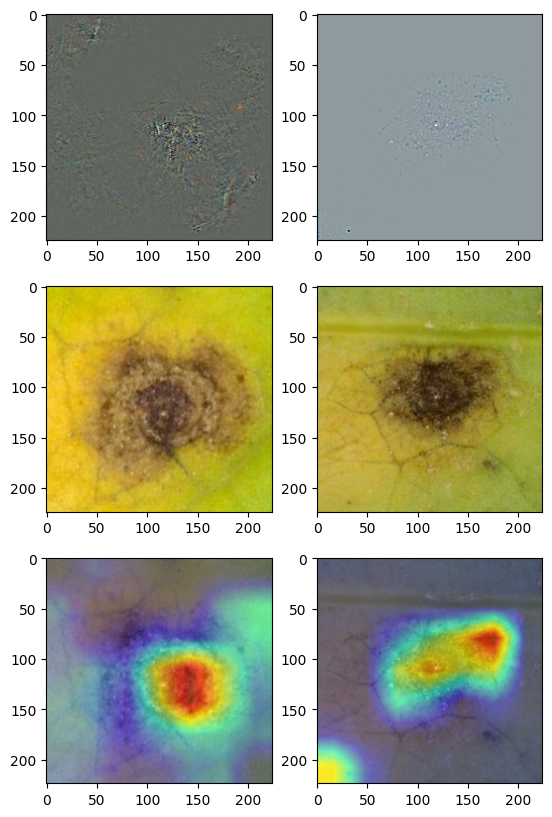

In [7]:
im = 4
input_recto, real = trainer.datasetRecto_test[im]
input_verso = trainer.datasetVerso_test[im][0]
input_recto = input_recto.to('cuda')
input_verso = input_verso.to('cuda')
input_recto = input_recto.unsqueeze(0).to('cuda')
input_verso = input_verso.unsqueeze(0).to('cuda')
gb = gb_model([input_recto,input_verso], target_category=None)
gc = vis_cam(input_tensors = [input_recto, input_verso],targets = None)
recto_cam = gc[0][0][0]
recto_gb = gb[0]

verso_cam = gc[0][1][0]
verso_gb = gb[1]

recto_cam_gb = np.zeros(shape=(224,224,3))
verso_cam_gb = np.zeros(shape=(224,224,3))
for i in range(3):                  
    recto_cam_gb[:,:,i] = np.multiply(recto_gb[:,:,i],recto_cam)
    recto_cam_gb[:,:,i] = recto_cam_gb[:,:,i] - np.min(recto_cam_gb[:,:,i])
    recto_cam_gb[:,:,i] = recto_cam_gb[:,:,i] / (1e-7 + np.max(recto_cam_gb[:,:,i]))
    recto_cam_gb[:,:,i] = np.float32(recto_cam_gb[:,:,i])
    verso_cam_gb[:,:,i] = np.multiply(verso_gb[:,:,i],verso_cam)
    verso_cam_gb[:,:,i] = verso_cam_gb[:,:,i] - np.min(verso_cam_gb[:,:,i])
    verso_cam_gb[:,:,i] = verso_cam_gb[:,:,i] / (1e-7 + np.max(verso_cam_gb[:,:,i]))
    verso_cam_gb[:,:,i] = np.float32(verso_cam_gb[:,:,i])
recto_cam_gb = cv2.cvtColor(recto_cam_gb.astype('float32'),cv2.COLOR_BGR2RGB)
verso_cam_gb = cv2.cvtColor(verso_cam_gb.astype('float32'),cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(3,2) 
f.set_figheight(10)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(recto_cam_gb)
axarr[1,0].imshow(image_net_postprocessing(input_recto).squeeze().cpu().numpy().transpose((1,2,0)))
axarr[2,0].imshow(image2cam(image_net_postprocessing(input_recto),recto_cam))  
axarr[0,1].imshow(verso_cam_gb)
axarr[1,1].imshow(image_net_postprocessing(input_verso).squeeze().cpu().numpy().transpose((1,2,0)))
axarr[2,1].imshow(image2cam(image_net_postprocessing(input_verso),verso_cam)) 

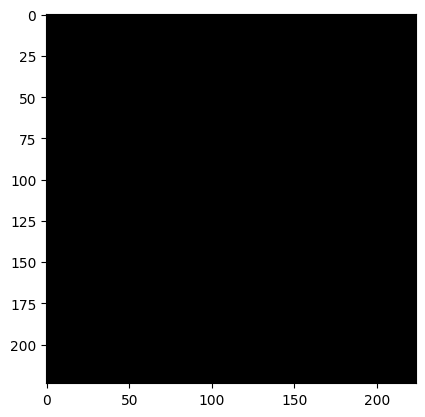

In [96]:
plt.imshow(recto_cam_gb)

In [98]:
cam_gb = np.zeros(shape=(224,224,3))
for i in range(3):                  
    cam_gb[:,:,i] = np.multiply(recto_gb[:,:,i],recto_cam)
    cam_gb[:,:,i] = cam_gb[:,:,i] - np.min(cam_gb[:,:,i])
    cam_gb[:,:,i] = cam_gb[:,:,i] / (1e-7 + np.max(cam_gb[:,:,i]))
    cam_gb[:,:,i] = np.float32(cam_gb[:,:,i])

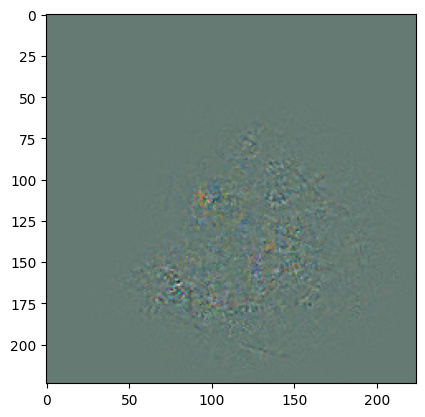

In [99]:
cam_gb = cv2.cvtColor(cam_gb.astype('float32'),cv2.COLOR_BGR2RGB)
plt.imshow(cam_gb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

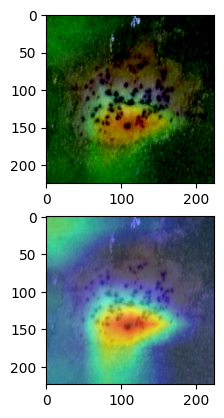

In [24]:
')plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(image2cam(input_recto,recto_cam))
inv_norm = (image2cam(input_recto,recto_cam))
axarr[1].imshow(image2cam(image_net_postprocessing(input_recto),recto_cam))

In [10]:
np.uint8(recto_cam_gb*255)

array([[[ 94, 103,  97],
        [ 94, 100,  92],
        [ 95,  98,  94],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]],

       [[ 96, 105,  97],
        [ 97, 102,  95],
        [ 97, 102,  96],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]],

       [[ 95, 100,  97],
        [ 97, 102,  96],
        [ 97, 104,  95],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]],

       ...,

       [[ 96, 100,  94],
        [ 96, 101,  94],
        [ 96, 101,  94],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]],

       [[ 97, 102,  94],
        [ 96, 101,  94],
        [ 96, 101,  94],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]],

       [[ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94],
        ...,
        [ 96, 101,  94],
        [ 96, 101,  94],
        [ 96, 101,  94]]

In [18]:
cv2.imwrite("image_test.jpeg",np.uint8(cv2.cvtColor(image2cam(image_net_postprocessing(input_recto),recto_cam).astype('float32'),cv2.COLOR_BGR2RGB)*255))

True

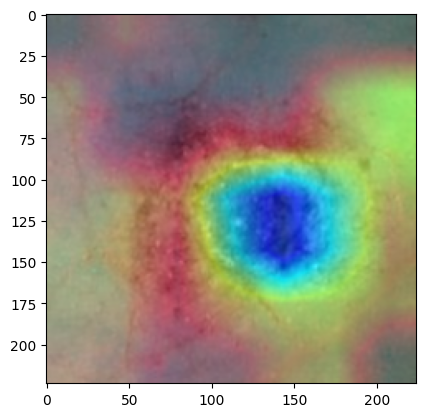

In [12]:
plt.imshow(np.uint8(cv2.cvtColor(image2cam(image_net_postprocessing(input_recto),recto_cam).astype('float32'),cv2.COLOR_BGR2RGB)*255))